In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Carregando dados

In [2]:
# Carregar os dados
df = pd.read_csv('data_yfinance/stocks_07-01-2025.csv')

# Filtrar as datas de interesse (2017-02-24 até hoje)
start_date = '2019-01-01'
df['Date'] = pd.to_datetime(df['Date'])
filtered_df = df[df['Date'] >= start_date]

# Removendo ".SA"

In [3]:
filtered_df['ticker'] = filtered_df['ticker'].apply(lambda x: x[:-3])
filtered_df

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_18124\2309112757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ticker'] = filtered_df['ticker'].apply(lambda x: x[:-3])


,Date,Open,High,Low,Close,ticker
462,2019-01-02,12.277999,12.277999,12.277999,12.277999,CALI3
463,2019-01-03,12.277999,12.277999,12.277999,12.277999,CALI3
464,2019-01-04,12.277999,12.277999,12.277999,12.277999,CALI3
465,2019-01-07,12.277999,12.277999,12.277999,12.277999,CALI3
466,2019-01-08,12.277999,12.277999,12.277999,12.277999,CALI3
...,...,...,...,...,...,...
818720,2024-12-27,5.270000,5.290000,5.060000,5.180000,BEEF3
818721,2024-12-30,5.180000,5.250000,5.080000,5.090000,BEEF3
818722,2025-01-02,5.100000,5.100000,4.800000,4.800000,BEEF3
818723,2025-01-03,4.800000,4.870000,4.710000,4.760000,BEEF3


# Cálculo estatísticas

In [4]:
# Calcular as estatísticas relevantes
def calculate_ticker_stats(df):
    # Calcular retornos diários
    df['Return'] = df.groupby('ticker')['Close'].pct_change()

    # Definindo uma taxa livre de risco anual
    annual_risk_free_rate = 0.0729  # 7,29% foi a média anual aproximada de 100% do CDI nos últimos 7 anos

    # Calcular o número de anos nos dados para anualizar os retornos diários
    num_years = (df['Date'].max() - df['Date'].min()).days / 365.25

    # Agrupando por 'ticker' e calculando as métricas necessárias
    ticker_stats = df.groupby('ticker').agg(
        avg_return=('Return', lambda x: (1 + x).prod() ** (1 / num_years) - 1),  # retorno médio anualizado
        volatility=('Return', 'std'),  # desvio padrão dos retornos
        cumulative_return=('Return', lambda x: (1 + x).prod() - 1),  # retorno acumulado
        sharpe_ratio=('Return', lambda x: ((x.mean() * 252 - annual_risk_free_rate) /
                                           (x.std() * (252 ** 0.5))) if x.std() != 0 else None)
        # Sharpe ratio anualizado, considerando 252 dias de negociação por ano
    ).reset_index()

    return ticker_stats

In [5]:
def calculate_rvi(avg_return, volatility, sharpe_ratio, alpha, beta, gamma):
    return alpha * avg_return + beta * volatility + gamma * sharpe_ratio


# Pesos para o modelo de decisão
weights = {
    'Conservador': {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.1},
    'Moderado': {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.8},
    'Arrojado': {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}
}

def apply_profiles(ticker_stats, weights):
    rvi_scores = {}
    for profile, params in weights.items():
        rvi_scores[profile] = ticker_stats.apply(
            lambda row: calculate_rvi(row['avg_return'], row['volatility'], row['sharpe_ratio'], 
                                      params['alpha'], params['beta'], params['gamma']),
            axis=1
        )
    return rvi_scores

# Calcular as estatísticas dos tickers
ticker_stats = calculate_ticker_stats(filtered_df)

# Aplicar os perfis de investimento
rvi_scores = apply_profiles(ticker_stats, weights)

# Adicionar os scores ao dataframe de estatísticas dos tickers
for profile, score in rvi_scores.items():
    ticker_stats[f'rvi_{profile}'] = score

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_18124\2540944230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df.groupby('ticker')['Close'].pct_change()


# Resultado

## Resultado ordenado por avg_return

In [6]:
df = ticker_stats.sort_values(by='avg_return', ascending=False)
df

,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
304,MMAQ3,2.070692,21.965146,849.003337,0.410491,17.820235,2.731977,3.894118
241,HETA3,0.695834,0.167374,22.940148,0.522066,0.255689,0.503974,0.625612
363,PRIO3,0.642917,0.037718,18.785632,1.024260,0.196892,0.887472,0.620531
305,MMAQ4,0.578596,0.376747,14.562126,0.398511,0.399108,0.414343,0.540403
330,NUTR3,0.541711,0.059635,12.500000,0.780303,0.179909,0.684377,0.517362
...,...,...,...,...,...,...,...,...
222,GFSA3,-0.533708,0.053608,-0.989817,-0.585585,-0.069043,-0.516478,-0.480164
262,JFEN3,-0.551767,0.070985,-0.991970,-0.298950,-0.028284,-0.287239,-0.464210
245,IFCM3,-0.576500,0.059556,-0.994291,-1.102758,-0.120281,-0.933901,-0.565520
21,AMER3,-0.665043,0.075236,-0.998607,-0.433216,-0.049637,-0.405553,-0.567832


## Resultado com aplicação de coloração

In [7]:
df_rvi = pd.DataFrame(ticker_stats)

# Função para aplicar coloração condicional
def color_negative_red(value):
    color = 'red' if value < 0 else 'black'
    return f'color: {color}'

# Aplicar coloração condicional a todas as colunas exceto 'ticker' e 'volatility'
styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])

# Aplicar um gradiente de cor para a coluna 'volatility'
styled_df = styled_df.background_gradient(subset=['volatility'], cmap='Reds')

# Aplicar gradiente verde para valores positivos
def background_gradient(s, m, M, cmap='Greens', low=0, high=0):
    rng = M - m
    norm = mcolors.Normalize(m - (rng * low), M + (rng * high))
    normed = norm(s.values)
    c = [plt.get_cmap(cmap)(x) for x in normed]
    return ['background-color: %s' % mcolors.rgb2hex(rgb[:3]) for rgb in c]

# Aplicar gradiente verde às colunas especificadas
columns_to_gradient = ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
for column in columns_to_gradient:
    styled_df = styled_df.apply(background_gradient, subset=[column], cmap='Greens', m=df_rvi[column].min(), M=df_rvi[column].max())

# Mostrar a tabela estilizada
styled_df

C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_18124\3579681204.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_rvi.style.applymap(color_negative_red, subset=pd.IndexSlice[:, ['avg_return', 'cumulative_return', 'sharpe_ratio', 'rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']])


,ticker,avg_return,volatility,cumulative_return,sharpe_ratio,rvi_Conservador,rvi_Moderado,rvi_Arrojado
0,AALR3,-0.087114,0.034230,-0.421887,-0.029458,0.015727,-0.028855,-0.069214
1,ABCB4,0.024865,0.020884,0.159125,0.021616,0.021355,0.021868,0.024142
2,ABEV3,-0.057807,0.018686,-0.300929,-0.300365,-0.020868,-0.244204,-0.074413
3,ADHM3,0.036855,0.043035,0.243091,0.231412,0.061255,0.193119,0.056929
4,AERI3,-0.368007,0.049461,-0.936639,-0.576320,-0.054864,-0.492910,-0.347091
5,AFLT3,0.047553,0.068685,0.322222,0.323501,0.092053,0.270425,0.077261
6,AGRO3,0.061307,0.020304,0.430094,0.123892,0.034763,0.107275,0.063465
7,AGXY3,-0.402068,0.048844,-0.954589,-0.894251,-0.090557,-0.750724,-0.406195
8,AHEB3,-0.105214,0.038503,-0.487468,0.012156,0.021496,0.003054,-0.079105
9,AHEB5,-0.115485,0.034662,-0.521837,-0.041440,0.012037,-0.041234,-0.093065


# Exportação dos dados

In [11]:
if not os.path.exists('data_yfinance'):
    os.makedirs('data_yfinance')
    
df.to_csv("data_yfinance\stocks_rvi_07-01-2025.csv", index=False)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Matheus Poletto\AppData\Local\Temp\ipykernel_18124\3988077680.py:4: SyntaxWarning: invalid escape sequence '\s'
  df.to_csv("data_yfinance\stocks_rvi_07-01-2025.csv", index=False)


# Criação de visuais

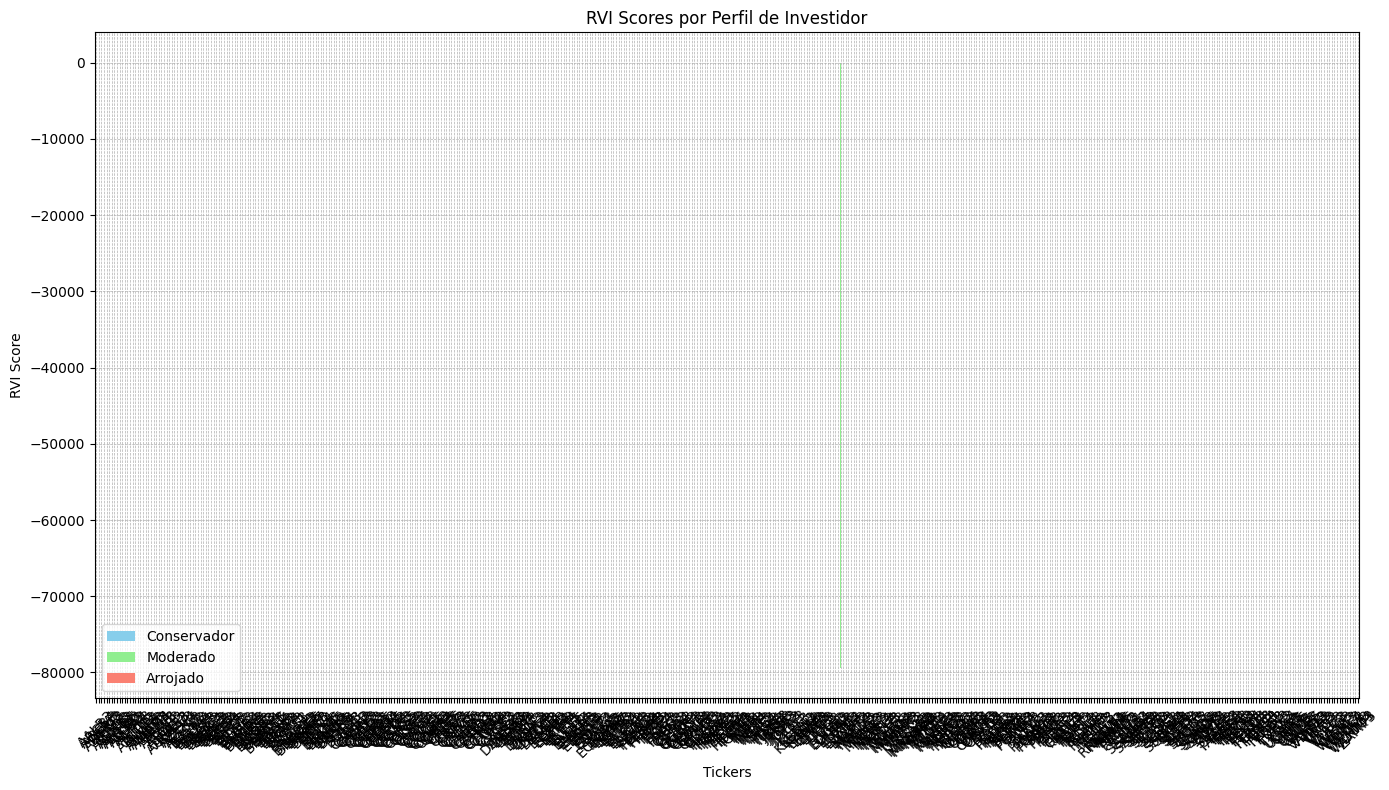

In [9]:
# Função para plotar um gráfico de barras colorido com grid
def plot_colorful_bars_with_grid(ticker_stats):
    profiles = ['rvi_Conservador', 'rvi_Moderado', 'rvi_Arrojado']
    colors = ['skyblue', 'lightgreen', 'salmon']
    ticker_stats.set_index('ticker')[profiles].plot(kind='bar', color=colors, figsize=(14, 8))
    plt.title('RVI Scores por Perfil de Investidor')
    plt.xlabel('Tickers')
    plt.ylabel('RVI Score')
    plt.legend(['Conservador', 'Moderado', 'Arrojado'])
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Plotar o gráfico colorido com grid
plot_colorful_bars_with_grid(ticker_stats)

In [10]:
# Visualizar as 5 primeiras ações únicas no dataframe
top_tickers = df['ticker'].unique()[:5]

# Filtrar o dataframe para incluir apenas as 5 ações
filtered_df = df[df['ticker'].isin(top_tickers)]

# Normalizar os preços de fechamento para cada ação
normalized_df = filtered_df.copy()
for ticker in top_tickers:
    initial_value = normalized_df[normalized_df['ticker'] == ticker]['Close'].iloc[0]
    normalized_df.loc[normalized_df['ticker'] == ticker, 'Normalized_Close'] = 100 * (normalized_df[normalized_df['ticker'] == ticker]['Close'] / initial_value - 1)

# Plotar as séries temporais normalizadas para cada ticker
plt.figure(figsize=(14, 8))
for ticker in top_tickers:
    plt.plot(normalized_df[normalized_df['ticker'] == ticker]['Date'], normalized_df[normalized_df['ticker'] == ticker]['Normalized_Close'], label=ticker)

plt.title('Preço de Fechamento Normalizado das Ações - Série Temporal (Porcentagem)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Normalizado (%)')
plt.legend(title='Ações')
plt.grid(True)
plt.show()

KeyError: 'Close'